## 1. Semantic Segmentation의 오류 보완 솔루션

DeepLab 기반 Semantic Segmentation은 각 픽셀을 사람 혹은 배경 중 하나로 분류하는 방식이기에 머리카락 같은 얇거나 반투명한 영역에서 문제가 발생한다.

이는 실제 카메라의 피사계심도처럼 연속적인 초점변화를 표현하지 못하는 구조적인 한계가 있다.

이에 대한 솔루션으로는 DeepLab이 생성한 semantic segmentation mask를 최종적으로 사용하지 않고, Depth 추정을 통해 얻은 Depth map을 이용하여 mask를 다시 구성한다.

## ==================================================================

## 2. 인물사진 문제점 지적사진

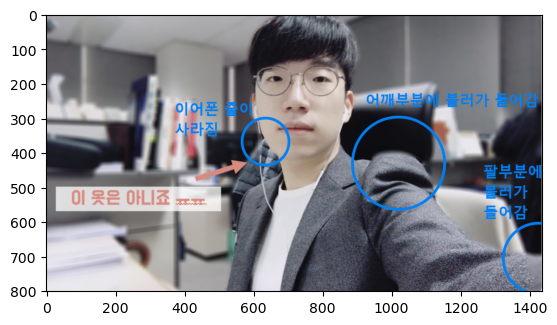

In [67]:
home_dir = os.getenv('HOME')
my_erimg_path = os.path.join(home_dir, "work/human_segmentation/images/prrr.png")
img_orig = cv2.imread(my_erimg_path)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## ==================================================================

## 3-(1). 아웃포커싱 적용한 사람

In [1]:
! pip install opencv-python pixellib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 70.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 70.4 MB/s eta 0:00:00:00:0100:01
  DEPRECATION: Building 'fvcore' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` o

In [2]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

In [3]:
home_dir = os.getenv('HOME')
my_img_path = os.path.join(home_dir, "work/human_segmentation/images/human(2).jpg")
img_orig = cv2.imread(my_img_path)

print(f"이미지 크기: {img_orig.shape}")

이미지 크기: (5712, 4284, 3)


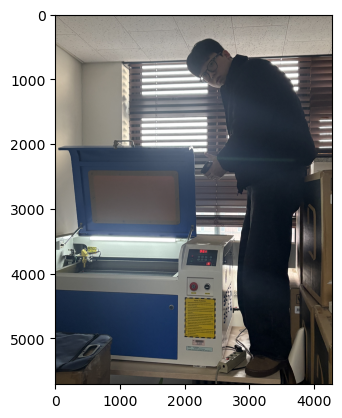

In [4]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
model = deeplabv3_resnet101(pretrained = True).eval()

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /home/jovyan/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:02<00:00, 96.5MB/s] 


In [6]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),
    T.ToTensor(),
])

In [7]:
input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [8]:
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

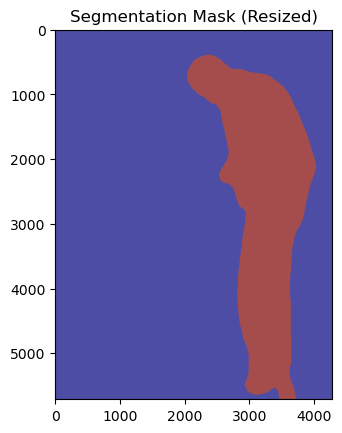

In [10]:
plt.imshow(output_predictions_resized, cmap="jet", alpha = 0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [11]:
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([ 0, 15], dtype=uint8)

In [12]:
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

background
person


In [13]:
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

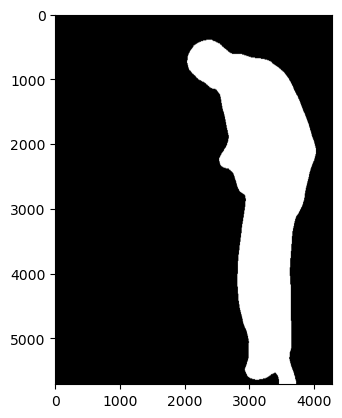

In [14]:
seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

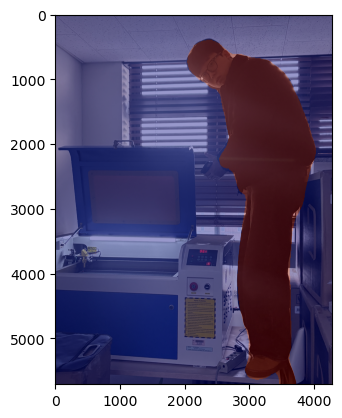

In [15]:
img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

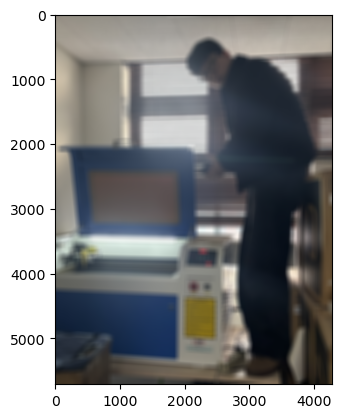

In [16]:
img_orig_blur = cv2.blur(img_orig, (100, 100))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

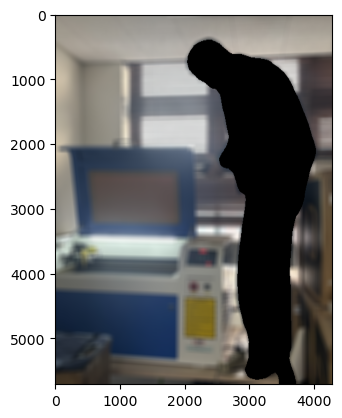

In [17]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

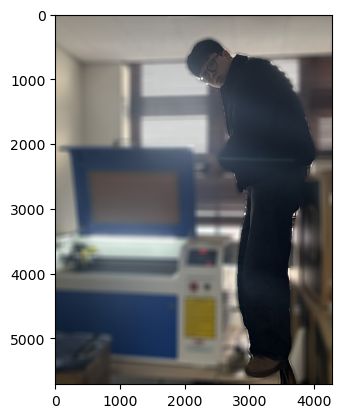

In [18]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 3-(2). 아웃포커싱 적용한 동물 

In [21]:
home_dir = os.getenv('HOME')
my_secimg_path = os.path.join(home_dir, "work/human_segmentation/images/meow.jpg")
img_orig = cv2.imread(my_secimg_path)

print(f"이미지 크기: {img_orig.shape}")

이미지 크기: (512, 683, 3)


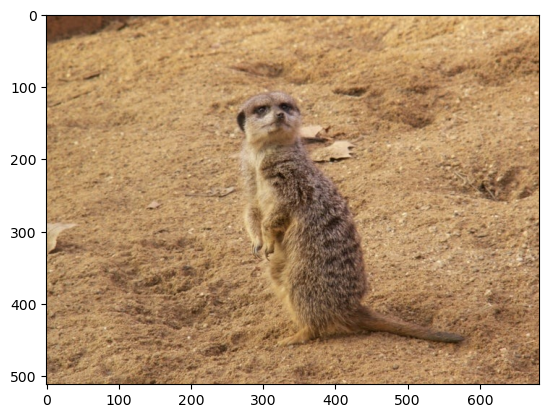

In [22]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
model = deeplabv3_resnet101(pretrained = True).eval()

In [24]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),
    T.ToTensor(),
])

In [25]:
input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [26]:
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

In [27]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

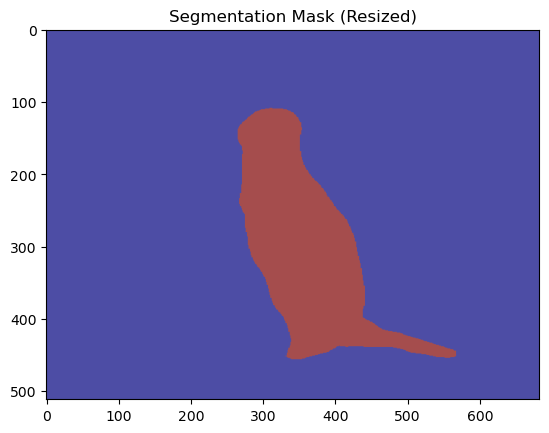

In [28]:
plt.imshow(output_predictions_resized, cmap="jet", alpha = 0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [29]:
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([ 0, 12], dtype=uint8)

In [30]:
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

background
dog


In [31]:
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

In [33]:
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

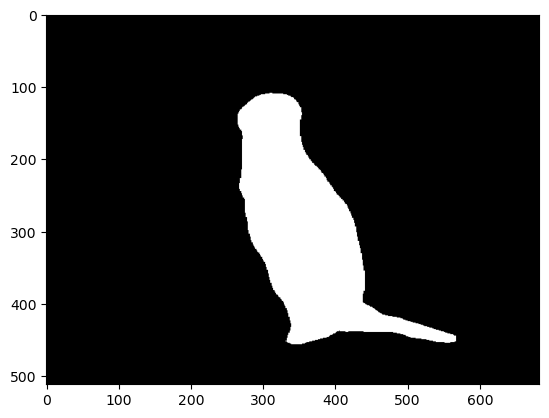

In [36]:
seg_map = (output_predictions_resized == 12)  # 클래스 ID 12 (개)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

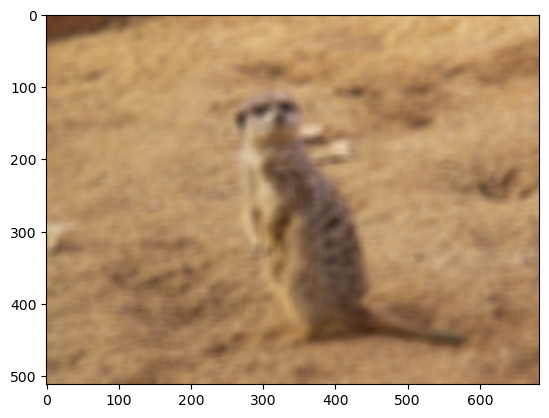

In [40]:
img_orig_blur = cv2.blur(img_orig, (13, 13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

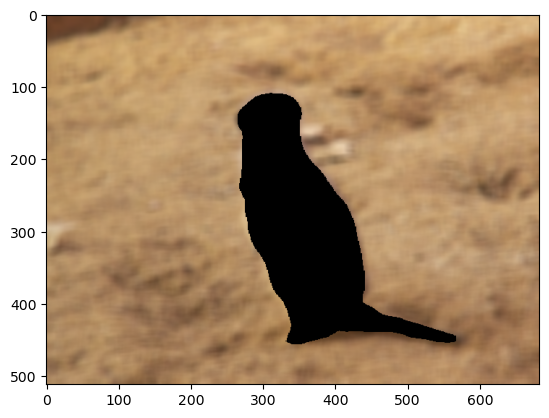

In [41]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

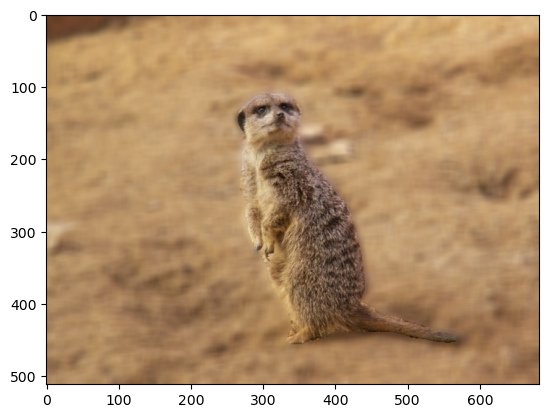

In [42]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 3-(3). 배경전환 크로마키 사진

In [44]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


In [51]:
meerkat_img_path  = os.path.expanduser("~/work/human_segmentation/images/meow.jpg")
sand_img_path = os.path.expanduser("~/work/human_segmentation/images/sand.jpg")

In [52]:
meerkat_img = cv2.imread(meerkat_img_path)
sand_img = cv2.imread(sand_img_path)

In [53]:
meerkat_img = cv2.cvtColor(meerkat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

In [54]:
print(f"원본 미어캣 이미지 크기: {meerkat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

원본 미어캣 이미지 크기: (512, 683, 3)
배경(사막) 이미지 크기: (222, 340, 3)


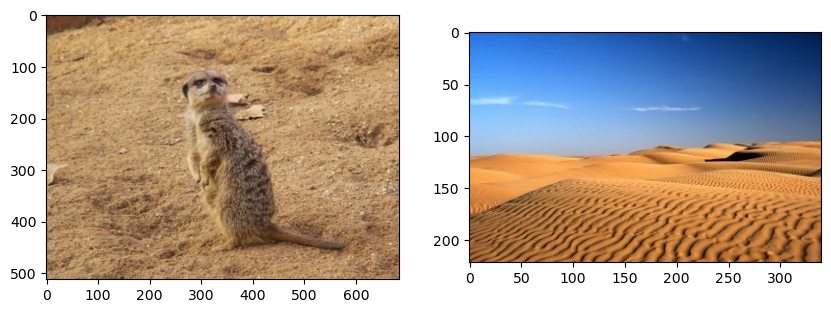

In [56]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(meerkat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [58]:
model = deeplabv3_resnet101(pretrained = True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),
    T.ToTensor(),
])

input_tensor = transform(meerkat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()
    
print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [60]:
output_predictions_resized = cv2.resize(output_predictions, (meerkat_img.shape[1], meerkat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (512, 683)


In [61]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [ 0 12]


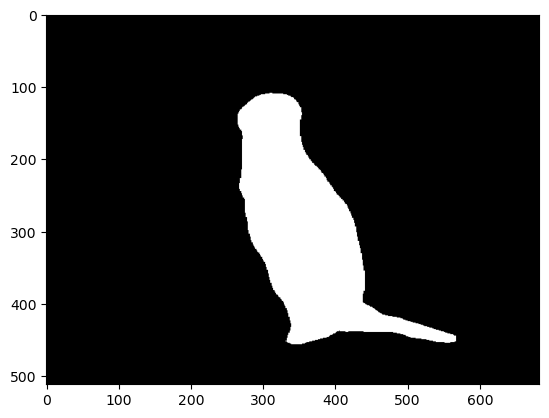

In [63]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized ==target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap = "gray")
plt.show()

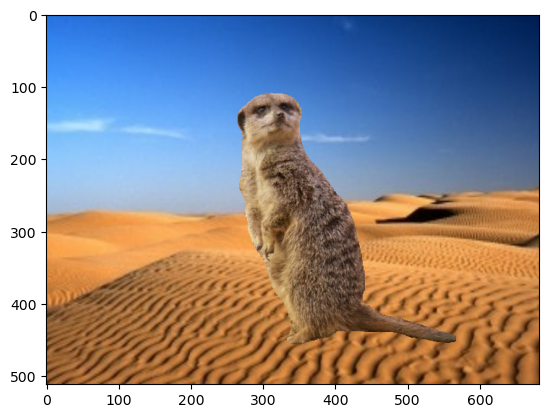

In [65]:
sand_img_resized = cv2.resize(sand_img, (meerkat_img.shape[1], meerkat_img.shape[0]))

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
result_img = np.where(img_mask_color == 255, meerkat_img, sand_img_resized)

plt.imshow(result_img)
plt.show()